In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy as sql
import pymysql
import sklearn.linear_model as skllm
import statsmodels.api as sm
import bin_time_data as bd
import query_database as qdb
import plot_lists
import load_Zidisha
%matplotlib inline

In [17]:
sns.set_context('talk')

In [18]:
#connect to db
zidisha_db = qdb.QueryDatabase('zidisha')

In [31]:
sql_dir = 'SQL_queries'

# List of all borrower countries
sql_query_file = 'country_name_list.sql'
df_countries = zidisha_db.source_query(sql_dir, sql_query_file, index_col_position=None)[0]
list_countries = df_countries.country_name.tolist()

# Big countries
list_countries = ['Burkina Faso', 'Ghana', 'Indonesia', 'Kenya']
labels_countries = ['All'] + list_countries

# Accepted borrower account creation dates
sql_query_file = 'borrowers_w_countries.sql'
list_df_new_borrowers = zidisha_db.source_query(sql_dir, sql_query_file, where_filter_col='country_name', where_filter_list=list_countries)
for df in list_df_new_borrowers:
    df.insert(0, 'number', range(len(df)))

# Borrower first loan creation dates
sql_query_file = 'first_loans_w_countries.sql'
list_df_first_loans = zidisha_db.source_query(sql_dir, sql_query_file, where_filter_col='country_name', where_filter_list=list_countries)
for df in list_df_first_loans:
    df.insert(0, 'number', range(len(df)))

# All loans
sql_query_file = 'all_loans.sql'
list_df_all_loans = zidisha_db.source_query(sql_dir, sql_query_file, where_filter_col='country_name', where_filter_list=list_countries)

# Fully funded loans
sql_query_file = 'fully_funded_loans.sql'
list_df_fully_funded_loans = zidisha_db.source_query(sql_dir, sql_query_file, where_filter_col='country_name', where_filter_list=list_countries)

# Load exchange rates
sql_query_file = 'exchange_rates_start.sql'
list_df_exchange_start = zidisha_db.source_query(sql_dir, sql_query_file, where_filter_col='country_name', where_filter_list=list_countries)

In [32]:
time_bins_edge = pd.date_range('2014-04-01','2015-09-01', None, '2W')
#time_bins_edge = pd.date_range('2012-02-01','2015-09-01', None, '2W')
#time_bins_edge = pd.date_range('2013-04-01','2015-09-01', None, '3W')
time_bins_center = bd.bin_centers_from_edges_time(time_bins_edge)

bin_short = lambda list_df, bin_type_str: bd.bin_list_to_data_frame(bd.bin_list_time(time_bins_edge, list_df, bin_type=bin_type_str, binned_col_labels=labels_countries))

df_all_loans_count = bin_short(list_df_all_loans, 'count')
df_fully_funded_count = bin_short(list_df_fully_funded_loans, 'count')
df_fund_rate = df_fully_funded_count.div(df_all_loans_count)

df_new_borrowers_count = bin_short(list_df_new_borrowers, 'count')
df_first_loans_count = bin_short(list_df_first_loans, 'count')
df_total_borrowers = bin_short(list_df_new_borrowers, 'mean')
df_total_first_loans = bin_short(list_df_first_loans, 'mean')

#list_df_new_borrowers_count = bd.bin_list_time(time_bins_edge, list_df_new_borrowers, bin_type='count', binned_col_labels=labels_countries)
#list_df_first_loans_count = bd.bin_list_time(time_bins_edge, list_df_first_loans, bin_type='count', binned_col_labels=labels_countries)
#list_df_total_borrowers = bd.bin_list_time(time_bins_edge, list_df_new_borrowers, bin_type='mean', binned_col_labels=labels_countries)
#list_df_total_first_loans = bd.bin_list_time(time_bins_edge, list_df_first_loans, bin_type='mean', binned_col_labels=labels_countries)

# Policies
df_loan_loss_fee = load_Zidisha.loan_loss_reserve_fee(time_bins_center)
df_max_invites = load_Zidisha.max_invites(time_bins_center)
df_max_first_loan = load_Zidisha.max_new_loan_size(time_bins_center)


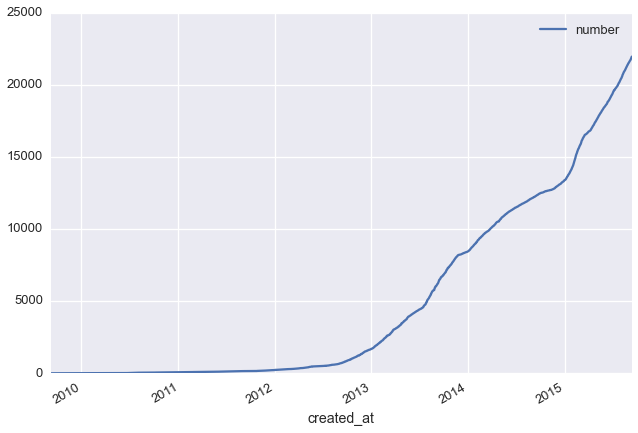

In [33]:
list_df_new_borrowers[0].plot()

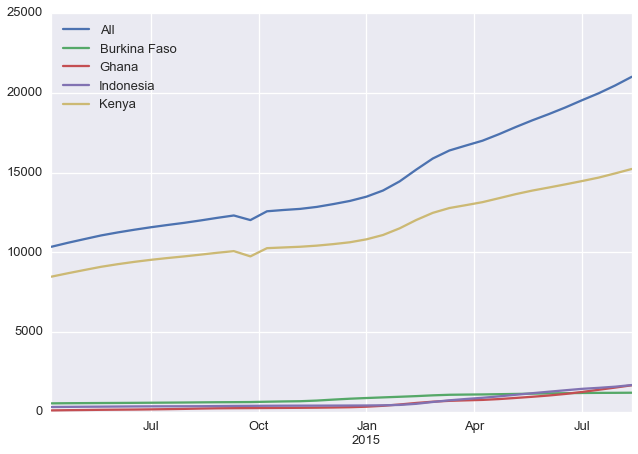

In [26]:
df_total_borrowers.plot()

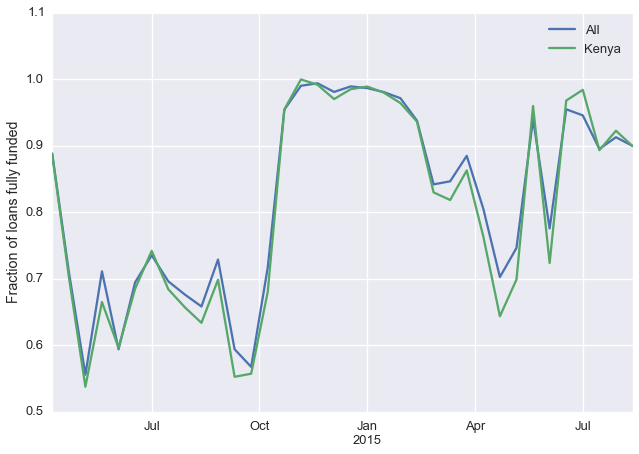

In [21]:
df_fund_rate[['All','Kenya']].plot()
plt.ylabel('Fraction of loans fully funded')

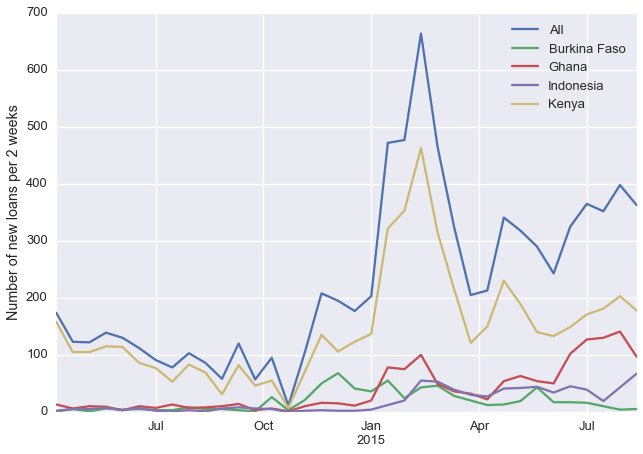

In [22]:
df_first_loans_count.plot()
plt.ylabel('Number of new loans per 2 weeks')

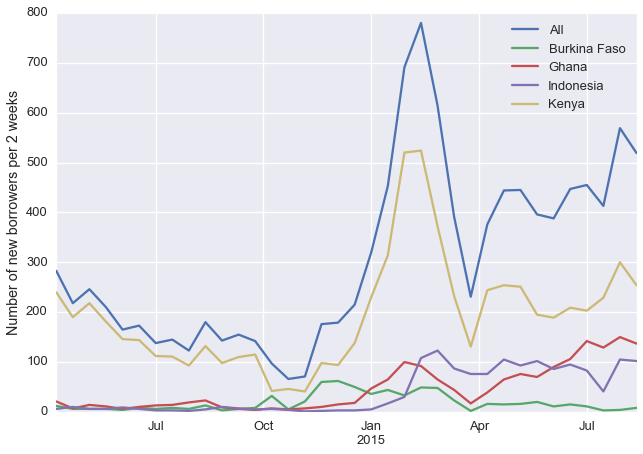

In [23]:
df_new_borrowers_count.plot()
plt.ylabel('Number of new borrowers per 2 weeks')

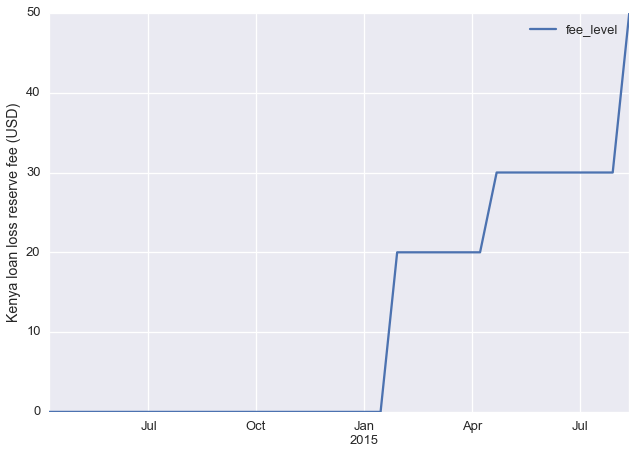

In [24]:
df_loan_loss_fee.plot()
plt.ylabel('Kenya loan loss reserve fee (USD)')

(0, 200)

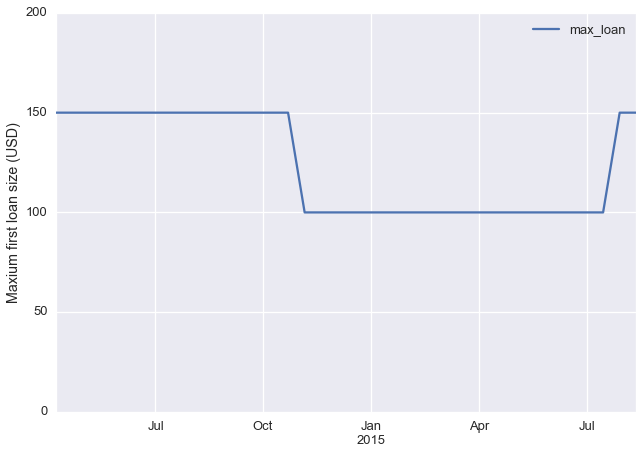

In [25]:
df_max_first_loan.plot()
plt.ylabel('Maxium first loan size (USD)')
plt.ylim([0, 200])

In [ ]:
#Fit matrix, n_samples x n_features
disperse_feature = df_avg_time_to_disperse.avg_time_to_disperse.values
fund_time_feature = df_avg_time_to_fund.avg_time_to_fund.values
invite_feature = df_avg_total_borrowers.avg_total_borrowers * df_max_invite.max_invites.values
fund_rate_feature = df_loans_fund_rate.loan_fund_rate.values
app_accept_feature = df_new_app_accept_rate.new_app_accept_frac.values
max_loan_feature = df_max_new_loan.max_loan.values

label_array = df_new_borrowers_counts.new_borrowers_per_period.values
feature_mat = np.transpose(np.array([disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))const_array = np.empty(len(time_bins_center))
const_array.fill(1)
feature_mat = np.transpose(np.array([const_array, disperse_feature, fund_time_feature, invite_feature, fund_rate_feature, app_accept_feature, max_loan_feature]))
model = sm.OLS(label_array, feature_mat)
results = model.fit()
print(results.summary())
labels = ['x1: Time to dispersal','x2: Time to fund','x3: Max invites * total borrowers','x4: Fraction funded','x5: Fraction applicants accepted','x6: Maximum loan limit']
print('\n'.join(labels)+'\n')

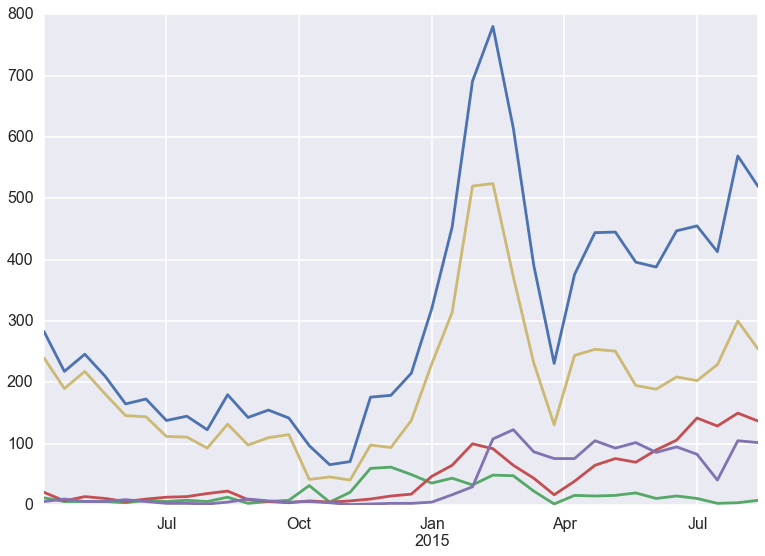

In [11]:
plot_lists.individual(bd.bin_data_frame_to_list(df_new_borrowers_count))

In [ ]:
for df in list_df_total_first_loans:
    df.plot()

In [ ]:
for index in range(len(labels_countries)):
    list_df_total_first_loans[index].plot()

In [ ]:
for index in range(len(labels_countries)):
    if list_df_total_first_loans[index].max()[0] > 600:
        list_df_total_first_loans[index].plot()

In [ ]:
for index in range(len(labels_countries)):
    print(labels_countries[index])
    plt.plot(time)
    list_df_new_borrowers_count[index].plot()

In [ ]:
for index in range(len(labels_countries)):
    print(labels_countries[index])
    list_df_new_borrowers_count[index].plot()

In [ ]:
list_df_new_borrowers[1]

In [ ]:
for df in list_df_new_borrowers:
    print(type(df))

In [ ]:
df_new_borrowers.columns.tolist()[0]

In [ ]:
time_bins_edge = pd.date_range('2012-02-01','2015-09-01', None, '2W')
time_bins_center = bd.bin_centers_from_edges_time(time_bins_edge)

In [ ]:
df_new_borrowers_counts = bd.bin_count_time(time_bins_edge, list_df_new_borrowers[0])
df_new_borrowers_counts.plot()

In [ ]:
time_bins_edge = pd.date_range('2012-02-01','2015-09-01', None, '2W')
df_first_loans_counts = bd.bin_count_time(time_bins_edge, list_df_first_loans[0])
df_first_loans_counts.plot()

In [ ]:
plt.plot(time_bins_center, df_first_loans_counts.data_counts)
plt.plot(time_bins_center, df_new_borrowers_counts.data_counts)

In [ ]:
df_first_loans

In [ ]:
df_first_loans['index']

In [ ]:
tlag = pd.DataFrame({'tdiff': df_first_loans.index.values - df_first_loans.created_at.values}, index=df_first_loans.index)
tlag = pd.DataFrame({'tdiff': tlag.tdiff.values}, index=tlag.index.values)
tlag.plot()

In [ ]:
x=np.timedelta64(tlag.tdiff[0])
date=x.astype('timedelta64[s]')
date.astype(int)

In [ ]:
'''
Combine acceptance rates with other terms, e.g. (theta0 + theta1*accept_rate)*

'''